# EDA Sephora Dataset

https://www.kaggle.com/datasets/dominoweir/skincare-product-ingredients

Price is in dollars.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

In [2]:
path = "D:/Documents-D/datasets/dermis"
df = pd.read_csv(f"{path}/sephora.csv")
print(len(df))
df.head()

1472


,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


## **Cleaning**

Hay muchas cosas por limpiar, sobre todo los ingredientes.

In [3]:
# pasar ingredientes a lista
df.ingredients = df.ingredients.str.lower().str.split(",")
df.ingredients = df.ingredients.apply(lambda x: [i.strip() for i in x])

# cantidad de ingredientes únicos
unique_ingredients = set()
for ingredients_list in df['ingredients']:
    unique_ingredients.update(ingredients_list)

num_unique_ingredients = len(unique_ingredients)
num_unique_ingredients

6134

In [4]:
def clean_ingredient(text):
    """
    Mantiene sólo caracteres alfanuméricos, paréntesis y espacios.
    """
    pattern = r'[^a-zA-Z0-9()\s]'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[\n\r\t\xa0]', '', text)
    text = text.strip('" ')
    text = text.replace('"', '')
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['ingredients_clean'] = df['ingredients'].apply(
    lambda lst: [clean_ingredient(ing) for ing in lst if clean_ingredient(ing)]
)

In [5]:
# contar ingredientes (sin mucho procesamiento)
all_ingredients = df.ingredients_clean.explode().str.strip()
ingredient_counts = Counter(all_ingredients)
ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count']).sort_values(by='Count', ascending=False)

In [6]:
# Hay unos códigos CI estándares para colorantes
# https://colour-index.com/introduction-to-the-colour-index
# Son por ejemplo: ci 123456
pattern = r'ci\s?\d{5}'
filtered_ingredient_counts_df = ingredient_counts_df[
    ingredient_counts_df['Ingredient'].str.contains(pattern, regex=True, na=False)
]

cis = filtered_ingredient_counts_df['Ingredient'].str.extract(r'ci\s?(\d{5})', flags=re.IGNORECASE)[0]
cis = list(set(cis))
print(cis) # lista de códigos CI únicos

['77492', '17200', '77489', '77266', '77007', '77000', '77491', '40800', '15985', '77742', '42053', '15850', '77288', '45410', '61565', '75130', '14700', '16035', '60730', '77947', '77019', '75810', '77289', '77499', '15510', '77497', '77891', '77861', '75120', '77510', '77163', '60725', '19140', '61570', '75470', '47005', '77480', '77120', '42090']


In [7]:
# Los códigos sólo se pueden obtener con una suscripción anual :C
# Le preguntamos a ChatGPT sus nombres
ci_dict = {
    "ci 77288": "chromium oxide green",
    "ci 19140": "tartrazine",
    "ci 15850": "d&c red no. 6 or 7",
    "ci 75130": "beta-carotene",
    "ci 77891": "titanium dioxide",
    "ci 15985": "sunset yellow fcf",
    "ci 77742": "manganese violet",
    "ci 75810": "chlorophyllin-copper complex",
    "ci 42090": "brilliant blue fcf",
    "ci 77497": "pigment brown 34",
    "ci 77289": "chromium hydroxide green",
    "ci 60725": "solvent violet 13",
    "ci 77480": "gold (pigment metal 3)",
    "ci 42053": "fast green fcf",
    "ci 17200": "acid red 33",
    "ci 61570": "green 5",
    "ci 15510": "orange 4",
    "ci 77120": "bismuth oxychloride",
    "ci 77489": "iron oxide black",
    "ci 77007": "ultramarine blue",
    "ci 61565": "green 6",
    "ci 77861": "tin oxide",
    "ci 16035": "allura red ac",
    "ci 77499": "iron oxide black",
    "ci 77510": "ferric ferrocyanide",
    "ci 77491": "iron oxide red",
    "ci 45410": "d&c red no. 28",
    "ci 77492": "iron oxide yellow",
    "ci 77019": "mica",
    "ci 75120": "annatto",
    "ci 77000": "aluminum powder",
    "ci 14700": "fd&c red no. 4",
    "ci 77266": "carbon black",
    "ci 40800": "d&c orange no. 5",
    "ci 60730": "ext. violet 2",
    "ci 77947": "zinc oxide",
    "ci 47005": "tartrazine",
    "ci 77163": "bismuth oxychloride",
    "ci 75470": "carmine"
}

def replace_ci_codes(ingredient_list):
    updated_list = []
    for ingredient in ingredient_list:
        replaced = False
        for key in ci_dict:
            # Check for key with or without space
            if key in ingredient or key.replace(" ", "") in ingredient:
                updated_list.append(ci_dict[key])
                replaced = True
                break
        if not replaced:
            updated_list.append(ingredient)
    return updated_list

df["ingredients_clean"] = df["ingredients_clean"].apply(replace_ci_codes)


In [8]:
# Algunos ingredientes no son realmente ingredientes,
# dicen algo como "visit the <xxx> store/boutique", así que los quitamos
df["ingredients_clean"] = df["ingredients_clean"].apply(
    lambda lst: [item for item in lst if not item.startswith("visit the")]
)

In [9]:
# contar cuántos ingredientes quedaron (después del procesamiento)
all_ingredients = df.ingredients_clean.explode().str.strip()
ingredient_counts = Counter(all_ingredients)
ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count']).sort_values(by='Count', ascending=False)
len(ingredient_counts)

5339

## **EDA**

Probablemente aún quedan ingredientes extraños... Pero seguimos con EDA.

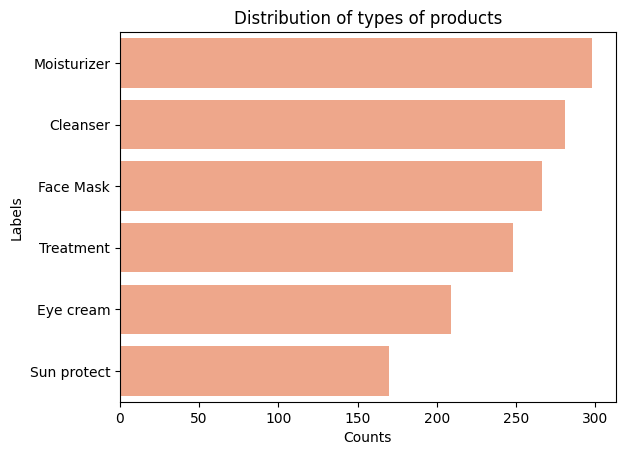

In [10]:
# Cuántos productos son de cada categoría (moisturizer, cleanser, etc.)
label_counts = df['Label'].value_counts()
sns.barplot(y=label_counts.index, x=label_counts.values, color='lightsalmon')
plt.title("Distribution of types of products")
plt.xlabel("Counts")
plt.ylabel("Labels")
plt.show()

### Análisis por marcas

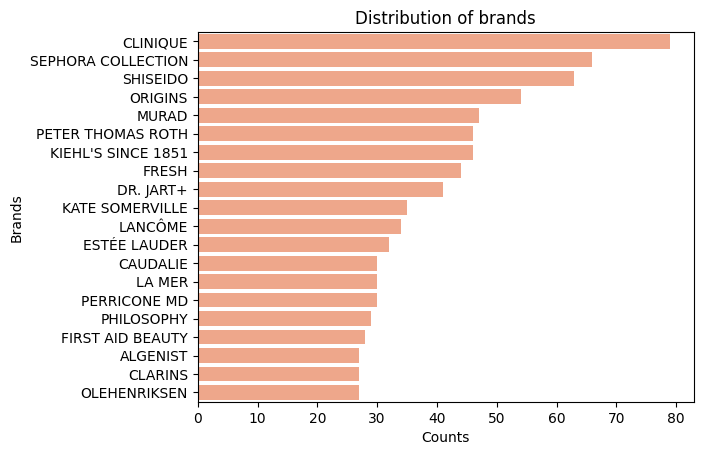

In [11]:
# Cuántos productos son de cada marca (Clinique, Lancome, etc.)
brand_counts = df['brand'].value_counts().sort_values(ascending=False).head(20)
sns.barplot(y=brand_counts.index, x=brand_counts.values, color='lightsalmon')
plt.title("Distribution of brands")
plt.xlabel("Counts")
plt.ylabel("Brands")
plt.show()

In [12]:
pastel_colors = sns.color_palette("pastel")
pastel_colors

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

<Figure size 1000x600 with 0 Axes>

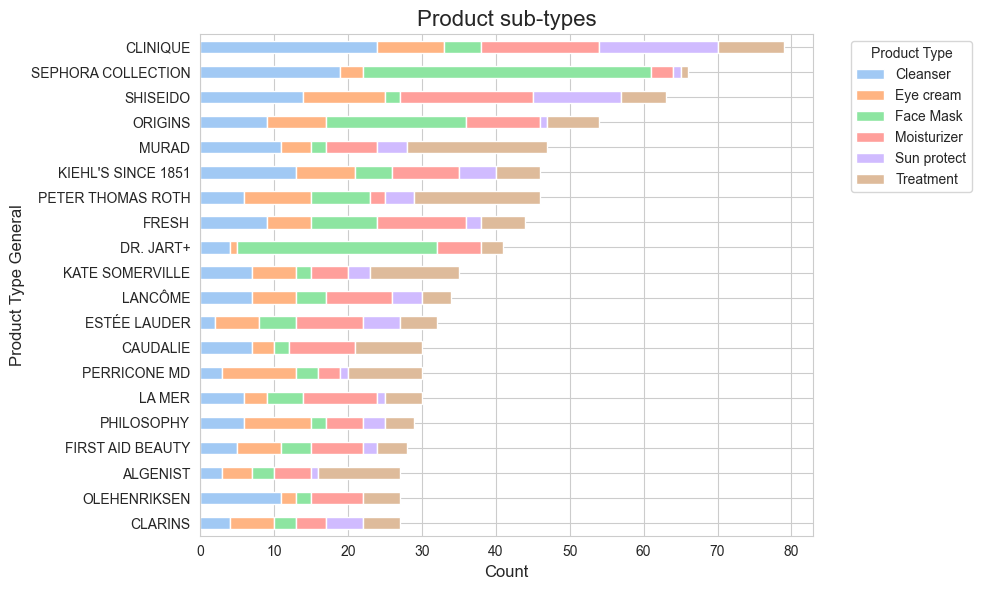

In [13]:
# Cuántos productos de cada tipo (cleanser, moisturizer, etc.) son de cada marca (Clinique, Lancome, etc.)
# es igual que el anterior pero incluye tipos
grouped_data = df.groupby(['brand', 'Label']).size().unstack(fill_value=0)
grouped_data = grouped_data.loc[brand_counts.sort_values(ascending=True).index]
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
grouped_data.plot(kind='barh', stacked=True, color=pastel_colors, figsize=(10, 6))

plt.title("Product sub-types", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Product Type General", fontsize=12)
plt.legend(title="Product Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

### Análisis según tipos de piel

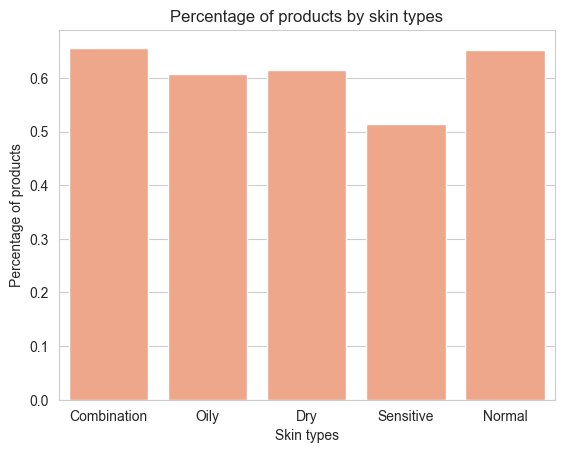

In [14]:
# cuántos productos por tipo de piel
type_counts = df[['Combination', 'Oily', 'Dry', 'Sensitive', 'Normal']].sum()
type_counts /= len(df)
sns.set_style("whitegrid")
sns.barplot(x=type_counts.index, y=type_counts.values, color='lightsalmon')
plt.title("Percentage of products by skin types")
plt.xlabel("Skin types")
plt.ylabel("Percentage of products")
plt.show()

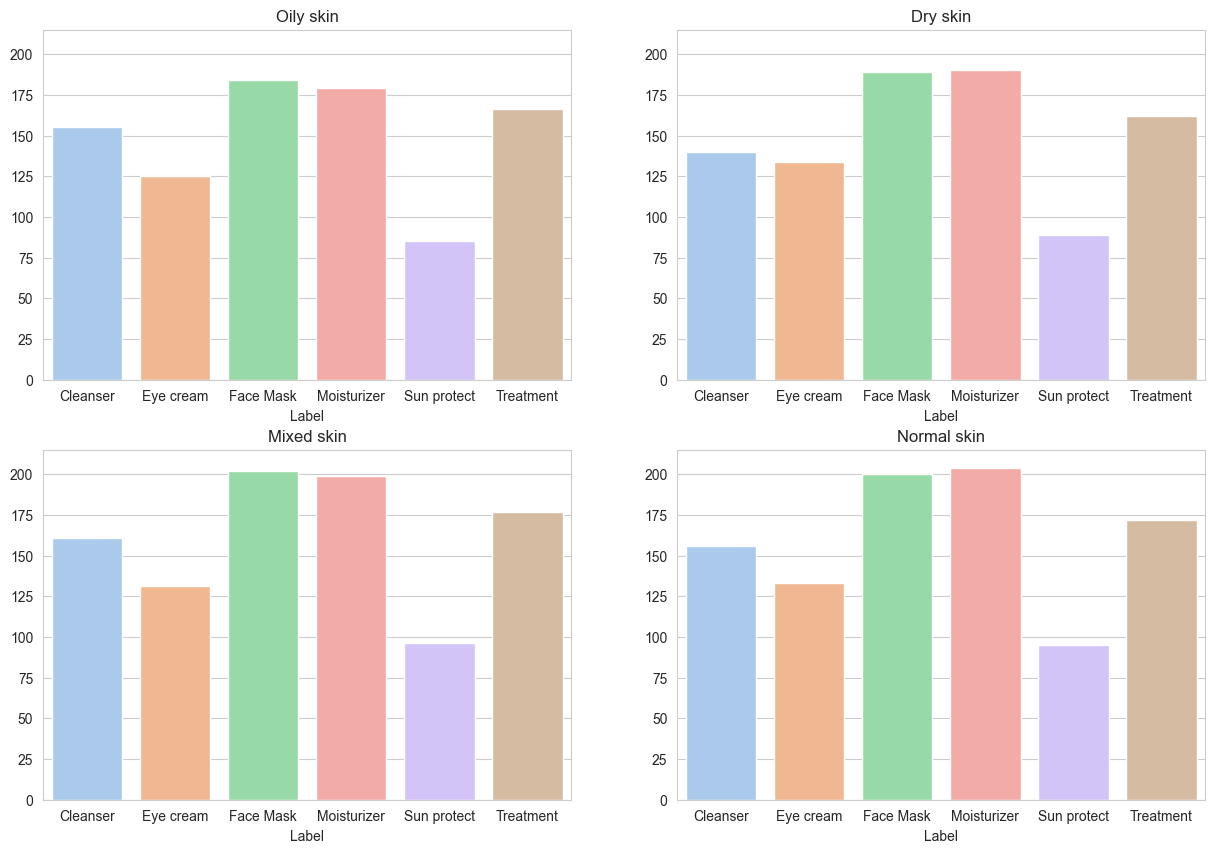

In [15]:
"""
Es lo mismo que el anterior, pero desagregado según los tipos de piel
dry, oily, normal, combination (mixta)
"""

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

oily = df[df['Oily'] == 1]
oily_counts = oily['Label'].value_counts().sort_index()
sns.barplot(x=oily_counts.index, y=oily_counts.values, hue = oily_counts.index, ax=axes[0, 0], palette='pastel')
axes[0, 0].set_title("Oily skin")

dry = df[df['Dry'] == 1]
dry_counts = dry['Label'].value_counts().sort_index()
sns.barplot(x=dry_counts.index, y=dry_counts.values, hue=dry_counts.index, ax=axes[0, 1], palette='pastel')
axes[0, 1].set_title("Dry skin")

mixed = df[df['Combination'] == 1]
mixed_counts = mixed['Label'].value_counts().sort_index()
sns.barplot(x=mixed_counts.index, y=mixed_counts.values, hue=mixed_counts.index, ax=axes[1, 0], palette='pastel')
axes[1, 0].set_title("Mixed skin")

normal = df[df['Normal'] == 1]
normal_counts = normal['Label'].value_counts().sort_index()
sns.barplot(x=normal_counts.index, y=normal_counts.values, hue=normal_counts.index, ax=axes[1, 1], palette='pastel')
axes[1, 1].set_title("Normal skin")

for ax in axes.flat:
    ax.set_ylim(0, 215)

plt.show()

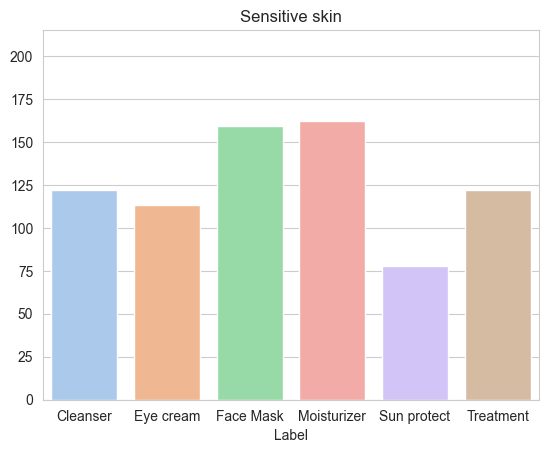

In [16]:
# Ahora para piel sensible
sensitive = df[df['Sensitive'] == 1]
sensitive_counts = sensitive['Label'].value_counts().sort_index()
sns.barplot(x=sensitive_counts.index, y=sensitive_counts.values, hue = sensitive_counts.index, palette='pastel')
plt.ylim(0, 215)
plt.title("Sensitive skin")
plt.show()

### Análisis por ingredientes

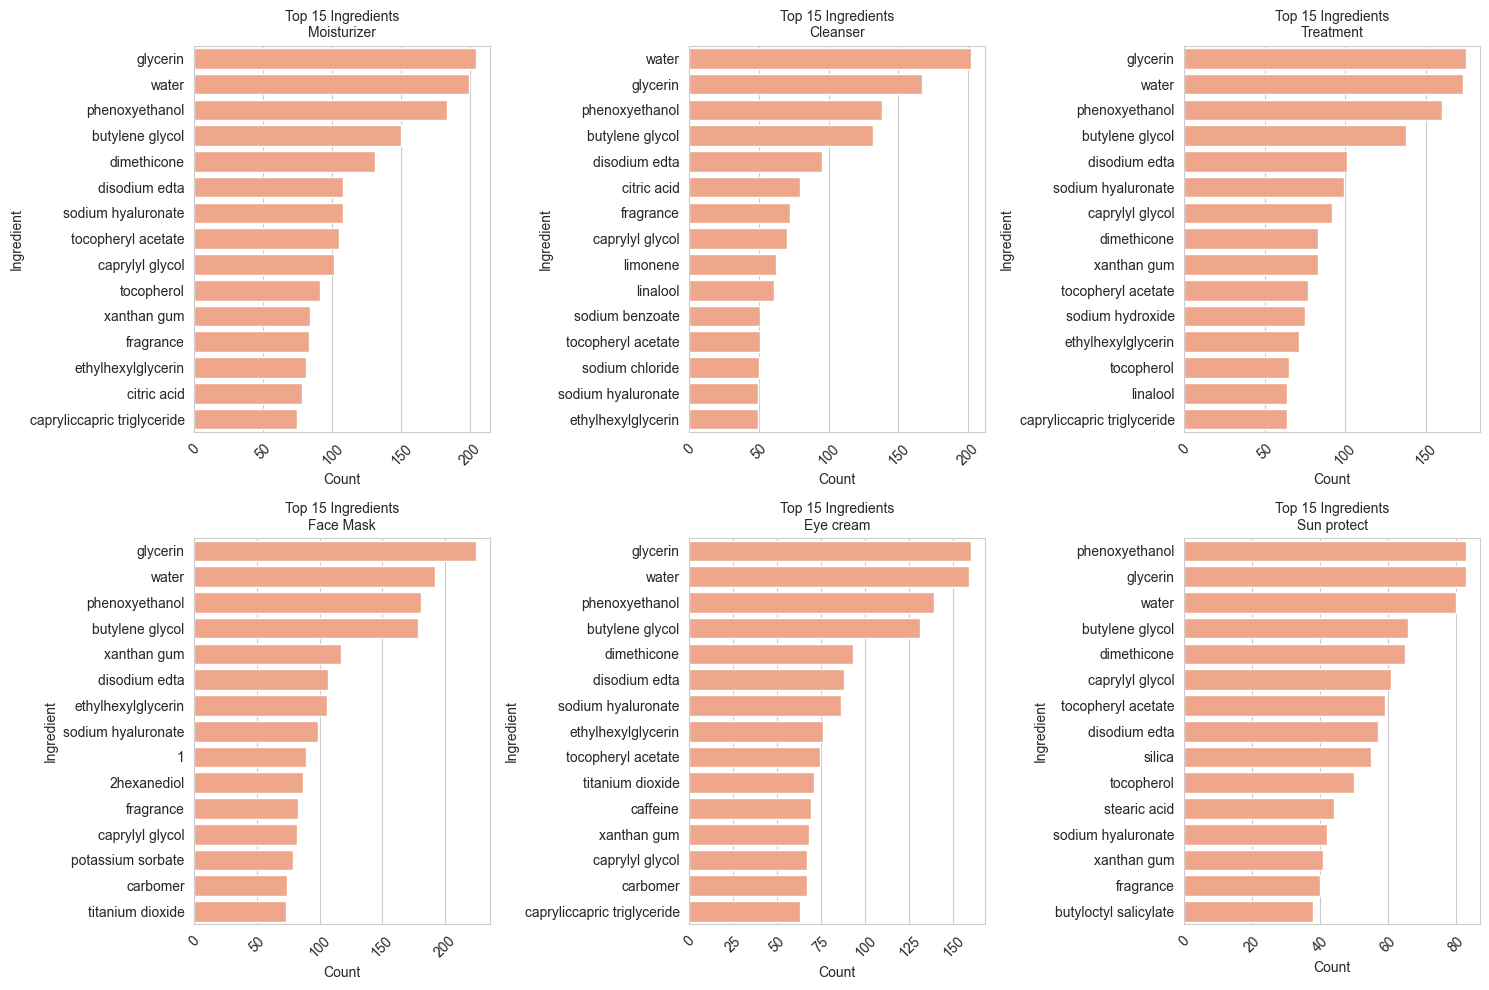

In [17]:
# Top k ingredientes por cada tipo de producto (moisturizer, cleanser, etc.)
topk = 15
product_types = df['Label'].unique()

fig, axes = plt.subplots(2, 3, figsize=(15, 10)) # 2 x 7
axes = axes.flatten()

for i, product_type in enumerate(product_types):
    product_type_ingredients = df[df.Label == product_type].ingredients_clean.explode().str.strip()
    ingredient_counts = Counter(product_type_ingredients)
    ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count']).sort_values(by='Count', ascending=False)
    
    sns.barplot(x='Count', y='Ingredient', data=ingredient_counts_df.head(topk), ax=axes[i], color="lightsalmon")
    axes[i].set_title(f"Top {topk} Ingredients\n{product_type}", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [18]:
def plot_ingredient_usage_by_product_type(df, ingredient_counts_df, start, count, title):
    """
    Plots a radar chart showing ingredient usage by product type.

    Parameters:
    - df: DataFrame containing product data with 'ingredients_clean' and 'Label' columns.
    - ingredient_counts_df: DataFrame containing ingredient counts with 'Ingredient' and 'Count' columns.
    - start: Starting index for selecting top ingredients.
    - count: Number of top ingredients to include in the plot.
    """
    top_ingredients = ingredient_counts_df.sort_values(by="Count", ascending=False).iloc[start: start + count]["Ingredient"].tolist()

    for ingredient in top_ingredients:
        df[ingredient] = df["ingredients_clean"].apply(lambda x: 1 if ingredient in x else 0)

    grouped = df.groupby("Label")[top_ingredients].mean()
    labels = top_ingredients
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    labels += labels[:1]
    angles += angles[:1]

    colors = sns.color_palette("pastel", n_colors=len(grouped))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for idx, (label, row) in enumerate(grouped.iterrows()):
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, color=colors[idx], label=label, linewidth=2)
        ax.fill(angles, values, color=colors[idx], alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels[:-1], fontsize=10)

    # Add radial ticks
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Example tick positions
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=8)  # Example tick labels
    ax.set_title(title, size=14, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), frameon=False)

    plt.tight_layout()
    plt.show()

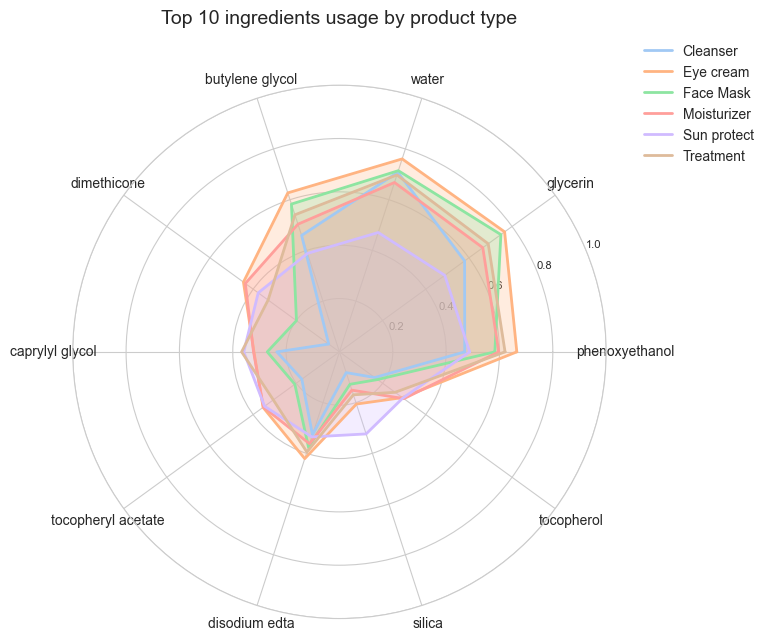

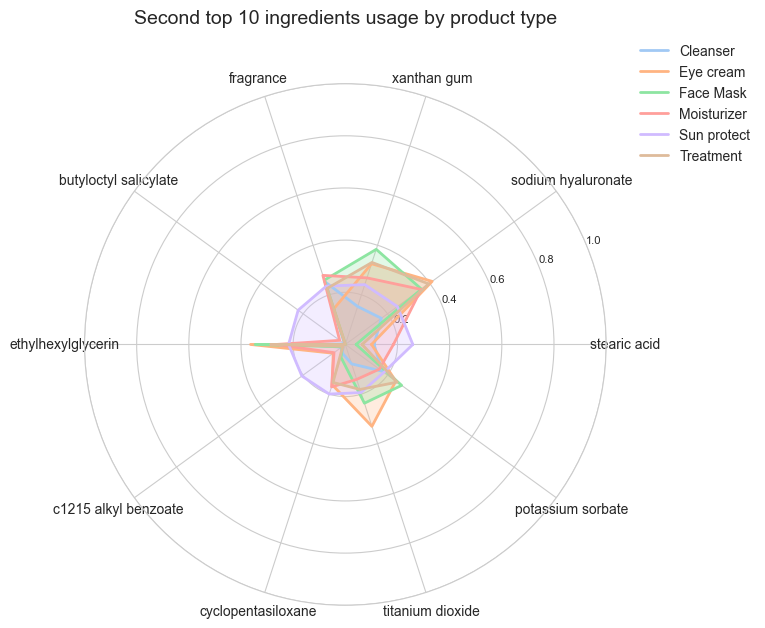

In [19]:
plot_ingredient_usage_by_product_type(df, ingredient_counts_df, start=0, count=10, title="Top 10 ingredients usage by product type")
plot_ingredient_usage_by_product_type(df, ingredient_counts_df, start=10, count=10, title="Second top 10 ingredients usage by product type")

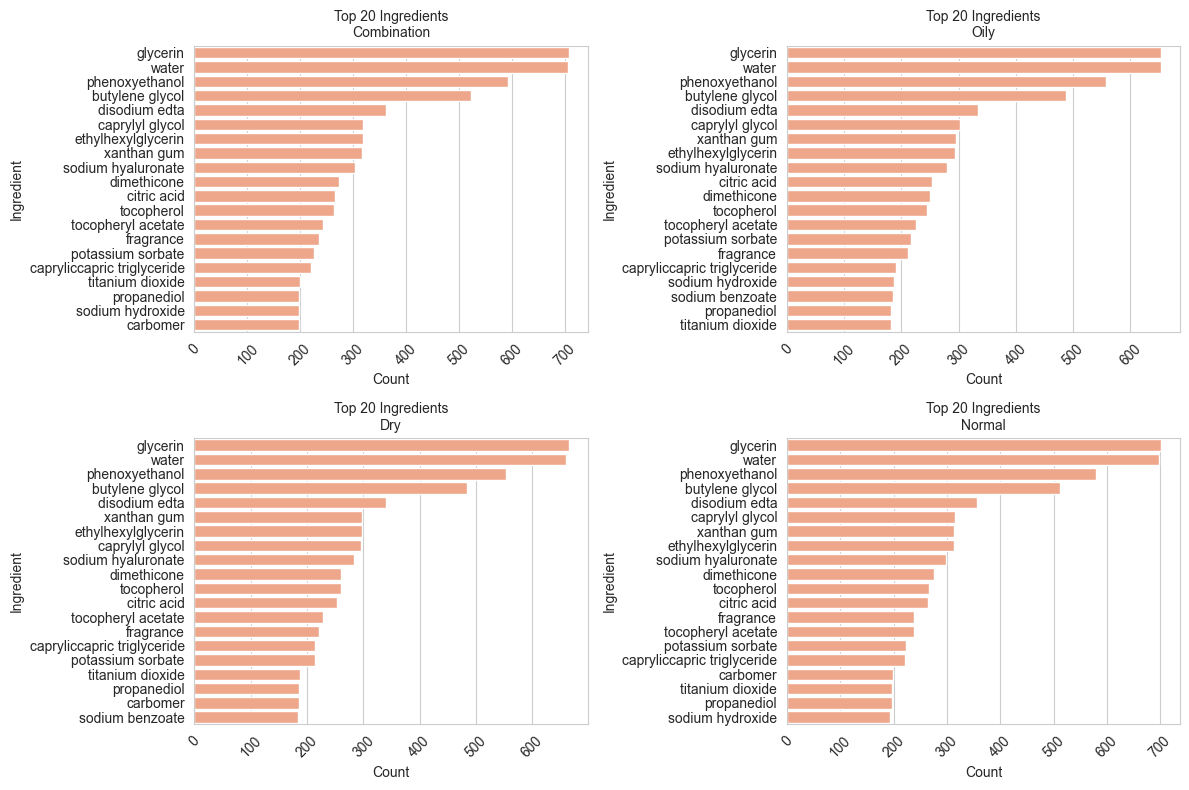

In [20]:
# Top k ingredientes presentes en productos según el tipo de piel
topk = 20
skin_types = ['Combination', 'Oily', 'Dry', 'Normal']

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) # 2 x 2
axes = axes.flatten()

for i, skin_type in enumerate(skin_types):
    skin_type_ingredients = df[df[skin_type] == 1].ingredients_clean.explode().str.strip()
    ingredient_counts = Counter(skin_type_ingredients)
    ingredient_counts_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Count']).sort_values(by='Count', ascending=False)
    
    sns.barplot(x='Count', y='Ingredient', data=ingredient_counts_df.head(topk), ax=axes[i], color="lightsalmon")
    axes[i].set_title(f"Top {topk} Ingredients\n{skin_type}", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

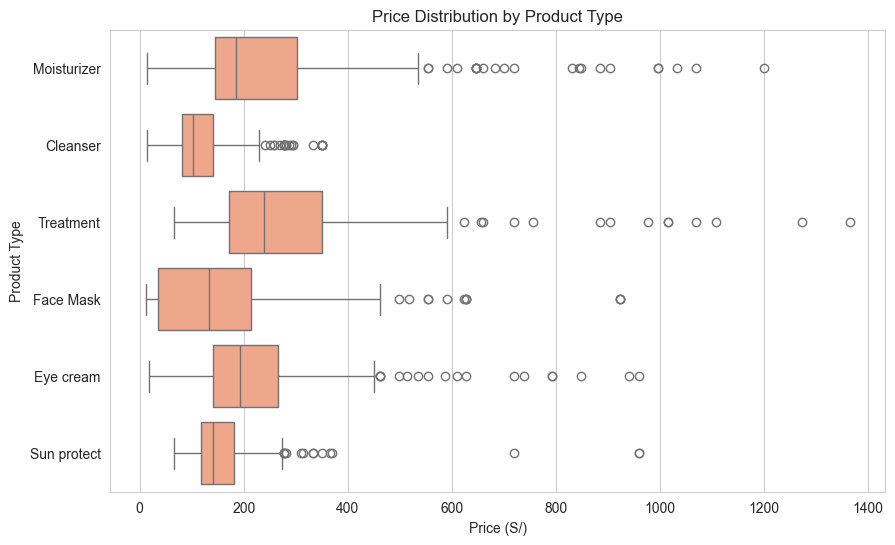

In [21]:
# Precio según tipo de producto (moisturizer, cleanser, etc.)
df['price_soles'] = df.price * 3.69
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot(data = df, y='Label', x='price_soles', color="lightsalmon")
plt.xlabel("Price (S/)")
plt.ylabel("Product Type")
plt.title("Price Distribution by Product Type")
plt.show()

## Ver químicos potencialmente dañinos

In [22]:
# lista de los químicos potencialmente dañinos
with open('chemicalnames (1).txt', 'r') as file:
    cscp_chemicals = [line.strip() for line in file]

print("total items: ", len(cscp_chemicals))
cscp_chemicals = list(set(cscp_chemicals))


total items:  1102


['Butylated hydroxyanisole',
 'Dichloroacetic acid',
 'Mineral oils, untreated and mildly treated',
 'Retinyl acetate',
 'Quartz',
 'Propylene glycol mono-t-butyl ether',
 'Retinol',
 'Ethylene oxide',
 'Formaldehyde (gas)',
 'Carbon black (airborne, unbound particles of respirable size)',
 'Trade Secret',
 'Ginkgo biloba extract',
 'Retinol/Retinyl High Dosage',
 'Retinyl palmitate',
 'Benzophenone',
 'Cocamide DEA',
 'Coffea arabica extract',
 'Cocamide MEA',
 'Safrole',
 'Benz[a]anthracene',
 'Coffee',
 'Genistein (purified)',
 'Vitamin A',
 'Silica',
 '1,4-Dioxane',
 'Acetaldehyde',
 'Mica',
 'Aloe vera, whole leaf extract',
 'Benzo[a]pyrene',
 'Caffeic acid',
 'Oil Orange SS',
 'Triethanolamine',
 'Titanium dioxide',
 'Vitamin A palmitate',
 'Methyl-E',
 'Caffeine',
 'Estragole']

In [ ]:
# limpiar
cscp_chemicals = [re.sub(r'\(.*?\)', '', elem).strip().lower() for elem in cscp_chemicals]
cscp_chemicals[3] = 'retynil'
cscp_chemicals[-1] = 'aloe vera'
cscp_chemicals

In [24]:
# Quedarnos con las filas donde algún ingrediente hace match con un químico
df_chemicals = df[df['ingredients_clean'].apply(lambda x: any(chem in ingredient for ingredient in x for chem in cscp_chemicals))]

# agregar encoding
for chem in cscp_chemicals:
    df_chemicals[chem] = df_chemicals['ingredients_clean'].apply(lambda x: 1 if any(chem in ingredient for ingredient in x) else 0)

df_chemicals

C:\Users\Windows 11\AppData\Local\Temp\ipykernel_1160\3552839801.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chemicals[chem] = df_chemicals['ingredients_clean'].apply(lambda x: 1 if any(chem in ingredient for ingredient in x) else 0)
C:\Users\Windows 11\AppData\Local\Temp\ipykernel_1160\3552839801.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chemicals[chem] = df_chemicals['ingredients_clean'].apply(lambda x: 1 if any(chem in ingredient for ingredient in x) else 0)
C:\Users\Windows 11\Ap

,Label,brand,name,price,rank,ingredients,Combination,Dry,Normal,Oily,...,mica,"aloe vera, whole leaf extract",benzo[a]pyrene,caffeic acid,oil orange ss,triethanolamine,vitamin a palmitate,methyl-e,caffeine,aloe vera
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"[algae (seaweed) extract, cyclopentasiloxane, ...",1,1,1,1,...,0,0,0,0,0,0,0,0,1,0
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"[water, snail secretion filtrate, phenyl trime...",1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5,Moisturizer,TATCHA,The Water Cream,68,4.2,"[water, saccharomyces/camellia sinensis leaf/c...",1,0,1,1,...,1,0,0,0,0,0,0,0,0,0
8,Moisturizer,KIEHL'S SINCE 1851,Ultra Facial Cream,29,4.4,"[water, glycerin, cyclohexasiloxane, squalane,...",1,1,1,1,...,0,0,0,0,0,1,0,0,0,0
15,Moisturizer,DRUNK ELEPHANT,The Littles™,90,4.4,"[beste™ no.9 jelly cleanser:\r\r\nwater, sodiu...",1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,Sun protect,PETER THOMAS ROTH,Oily Problem Skin Instant Mineral Powder SPF 30,30,3.7,"[titanium dioxide 13.65%, zinc oxide 14.70%, i...",0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1464,Sun protect,IT COSMETICS,Anti-Aging Armour™ Super Smart Skin-Perfecting...,38,4.1,"[water, cyclopentasiloxane, butyloctyl salicyl...",1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1466,Sun protect,KATE SOMERVILLE,Daily Deflector™ Moisturizer Broad Spectrum SP...,48,3.9,"[water, butylene glycol, peg-8, glycerin, unde...",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1467,Sun protect,KORRES,Yoghurt Nourishing Fluid Veil Face Sunscreen B...,35,3.9,"[water, alcohol denat., potassium cetyl phosph...",1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


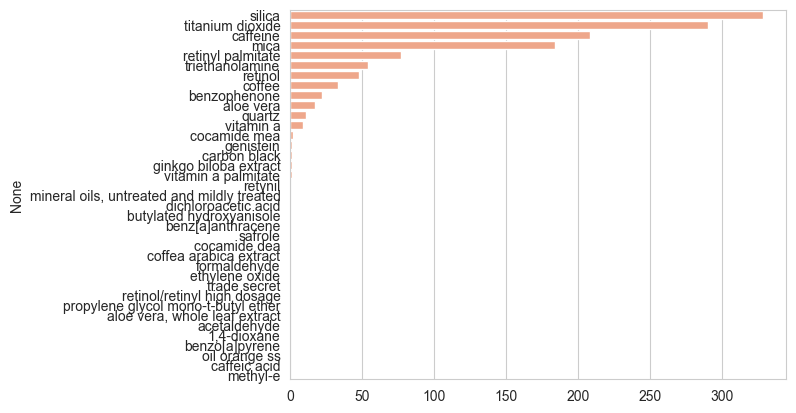

In [25]:
chemicals_counts = df_chemicals[cscp_chemicals].sum().sort_values(ascending=False)
chemicals_counts[chemicals_counts > 0]

# Graficar los químicos potencialmente dañinos
sns.set_style("whitegrid")
sns.barplot(y=chemicals_counts.index, x=chemicals_counts.values, color="lightsalmon")

plt.show()

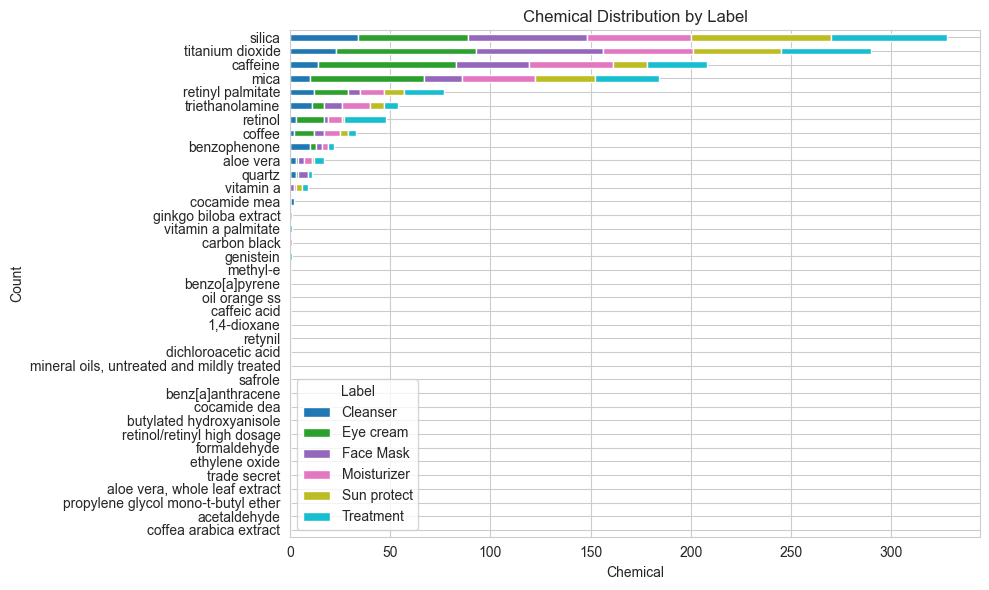

In [26]:
"""
Finalmente queremos ver la presencia de los químicos potencialmente dañinos
pero esta vez según el tipo de producto (moisturizer, cleanser, etc.)
"""
melted = df_chemicals.melt(id_vars='Label', value_vars=cscp_chemicals, var_name='Chemical', value_name='Presence')

melted = melted[melted['Presence'] == 1]
grouped = melted.groupby(['Chemical', 'Label']).size().reset_index(name='Count')
pivot = grouped.pivot(index='Chemical', columns='Label', values='Count').fillna(0)
pivot = pivot.reindex(chemicals_counts.sort_values(ascending=True).index)

pivot.plot(kind='barh', stacked=True, figsize=(10, 6), colormap='tab10')
plt.xlabel('Chemical')
plt.ylabel('Count')
plt.title('Chemical Distribution by Label')
plt.legend(title='Label')
plt.tight_layout()
plt.show()